# Comparative analysis of image datasets for hand development and regeneration in salamanders.

+ Regeneration:
  - normal
  - abnormal
+ Development

In [1]:
from pathlib import Path
from aicsimageio import imread
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.transform import resize

In [4]:
# Load png images
# and convert to numpy array
data_dir = Path("../data/")
image_shape = (128, 128)
images = {}

def load_dir(img_dir: Path):
    images = []
    for file in img_dir.glob("*.png"):
        img = imread(file)
        # Mean rgb values
        img = img[0][0][0]
        img = np.mean(img, axis=2)
        # resize img to 128x128
        img = resize(img, output_shape=image_shape)
        images.append(img)
    return images

images["development"] = load_dir(data_dir / 'development&regeneration' / "development")
images["normal_regeneration"] = load_dir(data_dir / 'normal&abnormal' / "Normal")
images["abnormal_regeneration"] = load_dir(data_dir / 'normal&abnormal' / "Abnormal")
for key, value in images.items():
    print(key, len(value))

samples = list(images.keys())


development 18
normal_regeneration 27
abnormal_regeneration 23


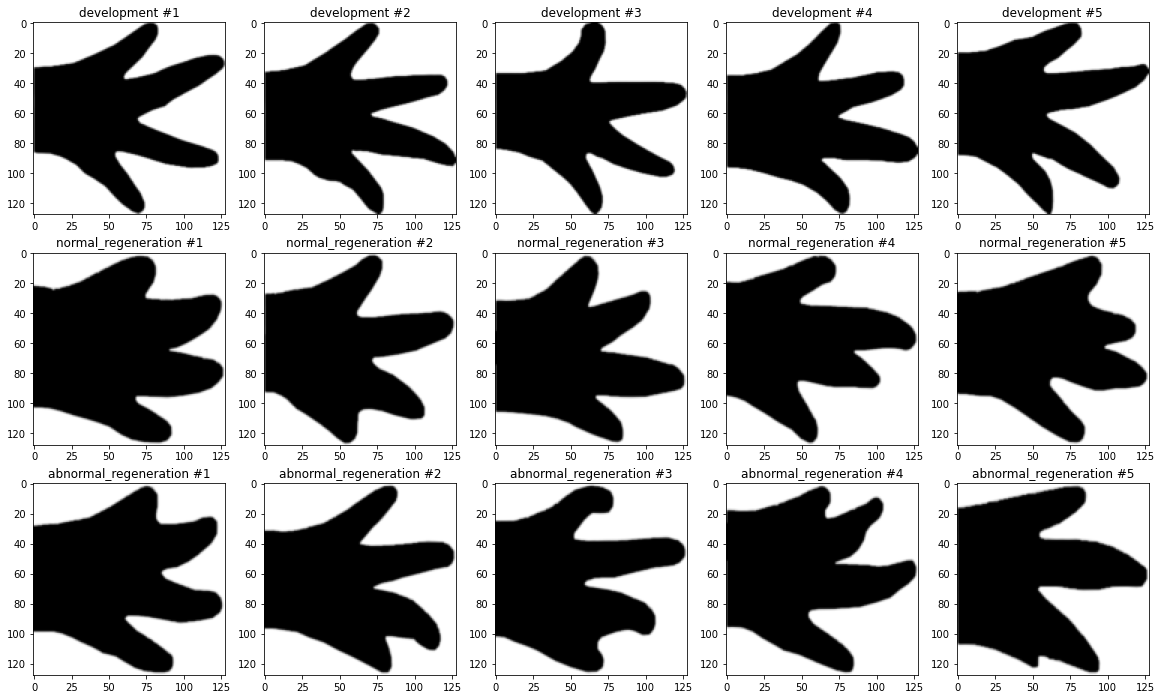

In [10]:
# display some images
n_col = 5
n_row = len(samples)
img_size = (4, 4)
fig, ax = plt.subplots(n_row, n_col, figsize=(img_size[0]*n_col, img_size[1]*n_row))
for col in range(n_col):
    for row, sample in enumerate(samples):
        ax[row, col].imshow(images[sample][col], cmap="gray")
        ax[row, col].set_title(f"{sample} #{col+1}")
fig.savefig("../figs/samples_development&normal&abnormal.pdf", bbox_inches='tight')

## Get mean image and compare between samples

In [8]:
# get mean images of images[sample]
mean_images = {}
for sample in samples:
    mean_images[sample] = np.mean(images[sample], axis=0)

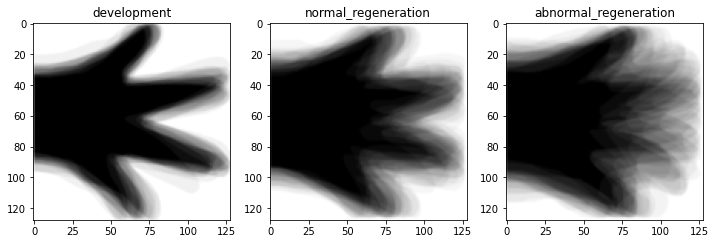

In [11]:
# display mean images
fig, ax = plt.subplots(1, len(samples), figsize=(img_size[0]*len(samples), img_size[1]))
for row, sample in enumerate(samples):
    ax[row].imshow(mean_images[sample], cmap="gray")
    ax[row].set_title(sample)
fig.savefig("../figs/mean_images_development&normal&abnormal.pdf", bbox_inches='tight')

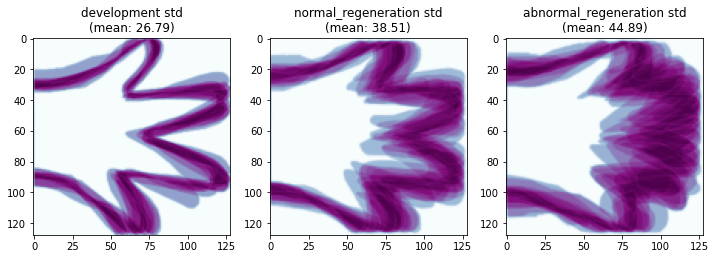

In [15]:
# get std images of images[sample]
std_images = {}
for sample in samples:
    std_images[sample] = np.std(images[sample], axis=0)

# display std images
fig, ax = plt.subplots(1, len(samples), figsize=(img_size[0]*len(samples), img_size[1]))
for row, sample in enumerate(samples):
    ax[row].imshow(std_images[sample], cmap="BuPu")
    mean_std_val = np.mean(std_images[sample])
    ax[row].set_title(f"{sample} std\n(mean: {mean_std_val:.2f})")
fig.savefig("../figs/std_images_development&normal&abnormal.pdf", bbox_inches='tight')

The standard deviation images of the development, normal & abnormal regeneration datasets show that the areas with darker colors have greater variation between the images. It can be observed that the average pixel standard deviation in the developmental images (26.79) is significantly smaller than that in the normal regeneration images (38.51) and the abnormal regeneration images (44.89).

In [16]:
# reshape std images to 1D array and gather into a dataframe
df = pd.DataFrame()
for sample in samples:
    df[sample] = std_images[sample].reshape(-1)
df = df.melt()
df.columns = ["sample", "std"]
# remove small std values
threshold = 1
df = df[df["std"] > threshold]

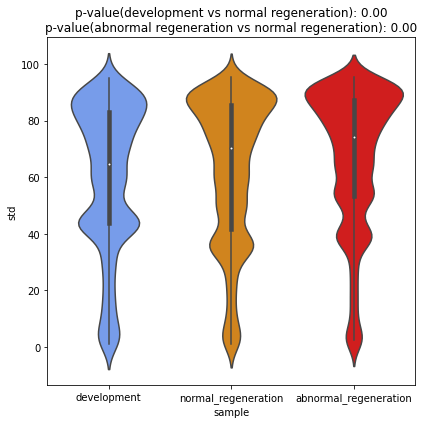

In [33]:
# draw violin plot and calculate p-value using ks-2samp
fig, ax = plt.subplots(1, 1, figsize=(img_size[0]*1.5, img_size[1]*1.5))
# chage color of violin plot (red and blue)
sns.set_palette(sns.color_palette(["#6495FD", "#EE8800", "#EE0000"]))
sns.violinplot(data=df, x="sample", y="std", ax=ax)
p_val_1 = mannwhitneyu(df[df["sample"] == "development"]["std"], df[df["sample"] == "normal_regeneration"]["std"])[1]
p_val_2 = mannwhitneyu(df[df["sample"] == "abnormal_regeneration"]["std"], df[df["sample"] == "normal_regeneration"]["std"])[1]
ax.set_title(
    f"p-value(development vs normal regeneration): {p_val_1:.2f}\n" +
    f"p-value(abnormal regeneration vs normal regeneration): {p_val_2:.2f}"
)
plt.tight_layout()
fig.savefig("../figs/std_violin_development&normal&abnormal.pdf", bbox_inches='tight')

Violin plot of the pixel differences in standard deviation images between development and regeneration images shows that the pixel std in regeneration images is higher overall. The difference is extremely significant according to Mann-Whitney U test (p-value = 0.0).

## Embedding analysis

Create embedding of images using Resnet-18, and then use UMAP to reduce the dimensionality of the embedding to 2D.

In [34]:
import torch
from torchvision.models import resnet18
import torch.nn as nn

model = resnet18(pretrained=True)
model.fc = nn.Identity()  # replace fully connected layer with identity function

def embedding_img(img):
    img_ = np.stack([img, img, img])
    img_ = img_.astype(np.float32)
    img_ = torch.from_numpy(img_)
    img_ = torch.unsqueeze(img_, 0)
    return model(img_).detach().numpy().reshape(-1)

c:\Users\Nangu\miniconda3\envs\qt\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Nangu\miniconda3\envs\qt\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
# embedding all images
embeddings = {}
for sample in samples:
    embeddings[sample] = []
    for img in images[sample]:
        embeddings[sample].append(embedding_img(img))

In [49]:
# reduce dimension of embeddings using UMAP
import umap.umap_ as umap
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_merged = sum(embeddings.values(), [])
embeddings_2d_merged = reducer.fit_transform(embeddings_merged)
embeddings_2d = {}
start = 0
for i, sample in enumerate(samples):
    end = start + len(embeddings[sample])
    embeddings_2d[sample] = embeddings_2d_merged[start:end]
    start = end

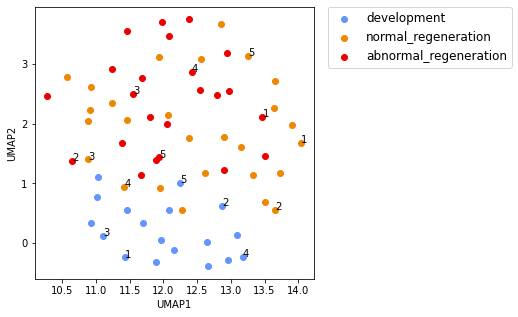

In [56]:
# draw scatter plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for sample in samples:
    ax.scatter(embeddings_2d[sample][:, 0], embeddings_2d[sample][:, 1], label=sample)
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
# mark first 5 images on each sample, with NO of images
for sample in samples:
    for i in range(5):
        ax.annotate(f"{i+1}", (embeddings_2d[sample][i, 0], embeddings_2d[sample][i, 1]))
fig.savefig("../figs/embedding_2d_development&normal&abnormal.pdf", bbox_inches='tight')

Scatter plot of the dataset after Resnet embedding and UMAP dimensionality reduction, where each spot represents an image of salamander hand. The closer two points are, the more similar their features. The numbers annotated in the plot represent the image numbers in the sample images.